# Evaluating Alignment of Text-to-image Diffusion Models

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/evaluating-alignment-of-text-to-image-diffusion-models.ipynb)

Click the `Open in Colab` button to run the cookbook on Google Colab.

## Introduction

It is a common scenario to evaluate text-to-image models for its alignment to the prompt. One way to test it is to use a set of prompts, consisting of number of objects and their basic physical properties (e.g. color), to generate images and manually evaluate the results. This process can be greatly improved using object detection models.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jun 12 12:59:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install required packages

In this cookbook, we'll leverage the following Python packages:
* [diffusers](https://huggingface.co/docs/diffusers/en/index) for image generation pipelines,
* [inference](https://inference.roboflow.com/) for running object detection,
* [supervision](https://supervision.roboflow.com/) for visualizing detections.

In [2]:
!pip install -q torch diffusers accelerate inference-gpu[yolo-world] dill git+https://github.com/openai/CLIP.git supervision==0.19.0rc5

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.4 M

## Imports

In [3]:
import itertools
import cv2
from diffusers import StableDiffusionXLPipeline
import numpy as np
from PIL import Image
import supervision as sv
import torch
from inference.models import YOLOWorld

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Generating an image

We'll use [SDXL](https://huggingface.co/docs/diffusers/using-diffusers/sdxl) model to generate our image. Let's initialize our pipeline first:

In [4]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to("cuda")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In this example, we'll focus on generating an image of a black cat playing with a blue ball next to a parked white car. We don't care about the aesthetic aspect of the image.

  0%|          | 0/50 [00:00<?, ?it/s]

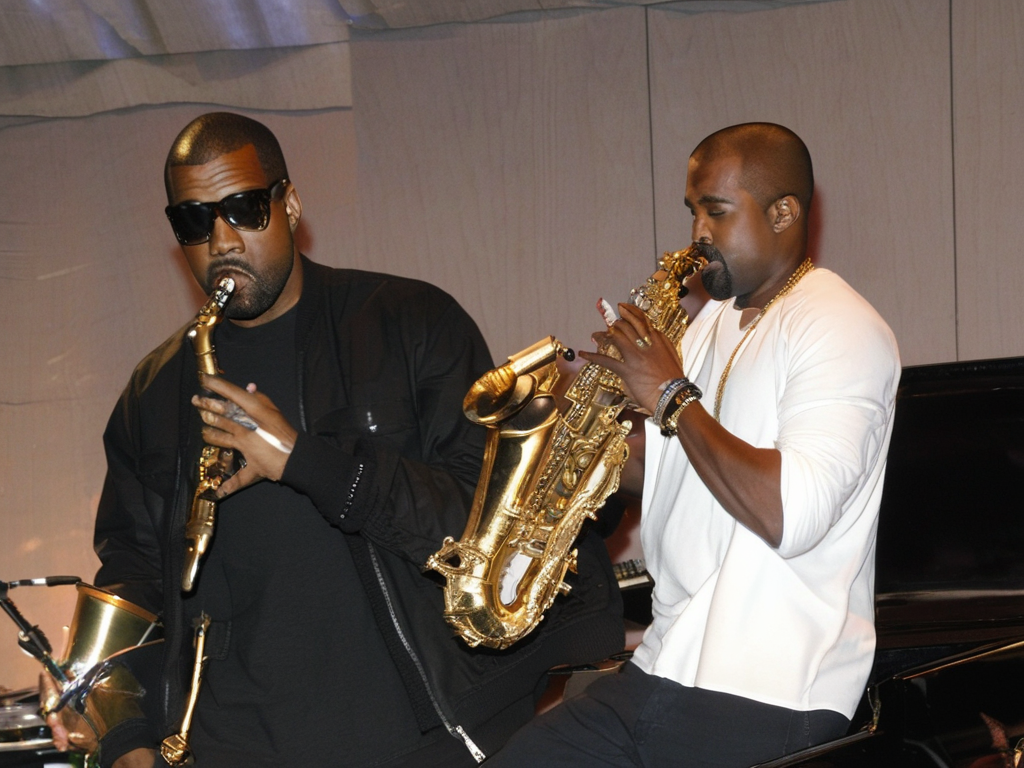

In [6]:
PROMPT = " Kanye west playing saxophone"
NEGATIVE_PROMPT = "low quality, blurred, text, illustration"
WIDTH, HEIGHT = 1024, 768
SEED = 9213799

image = pipeline(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    generator=torch.manual_seed(SEED),
    width=WIDTH,
    height=HEIGHT,
).images[0]
image

Not bad! The results seem to be well-aligned with the prompt.

## Detecting objects

Now, let's see how can we detect the objects automatically. For this, we'll use [YOLO-World](https://inference.roboflow.com/) model from `inference` library.

In [7]:
model = YOLOWorld(model_id="yolo_world/l")

Creating inference sessions


CLIP model loaded in 34.03 seconds


YOLO-World model allows us to [define our own set of labels](https://docs.ultralytics.com/models/yolo-world/#set-prompts). Let's create it by combining lists of pre-defined colors and objects.

In [16]:
COLORS = [ "gold", "black",  "white", "orange"]
OBJECTS = ["saxophone", "chain", "sunglasses", "bracelet", "jacket", "t-shirt", "person"]
CLASSES = [f"{color} {obj}" for color, obj in itertools.product(COLORS, OBJECTS)]
print("Number of labels:", len(CLASSES))

Number of labels: 28


Let's feed these labels into our model:

In [17]:
model.set_classes(CLASSES)

Time to detect some objects!

In [18]:
results = model.infer(image)

We'll convert the results to the [sv.Detections](https://supervision.roboflow.com/latest/detection/core/#supervision.detection.core.Detections) format to enable features like filtering or annotations.

In [19]:
detections = sv.Detections.from_inference(results)

Speaking of which: we only care about strong detections, so we filter out ones that are below 0.6 confidence.

In [20]:
valid_detections = detections[detections.confidence >= 0.6]

A quick peek on the detected labels and their score:

In [21]:
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(valid_detections.class_id, valid_detections.confidence)
]
labels

['gold saxophone 0.98', 'gold saxophone 0.91', 'black sunglasses 0.87']

## Visualizing results

Now, let's use the power of `supervision` to visualize them. Our output image is in [Pillow](https://pillow.readthedocs.io/en/stable/index.html) format, but annotators can accept the image to be a BGR `np.ndarray` or pillow's `PIL.Image.Image`.

Time to define how we want our detections to be visualized. A combination of [sv.BoundingBoxAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [sv.LabelAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator) should be perfect.

In [22]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5,text_color=sv.Color.BLACK)

Finally, annotating our image is as simple as calling `annotate` methods from our annotators:

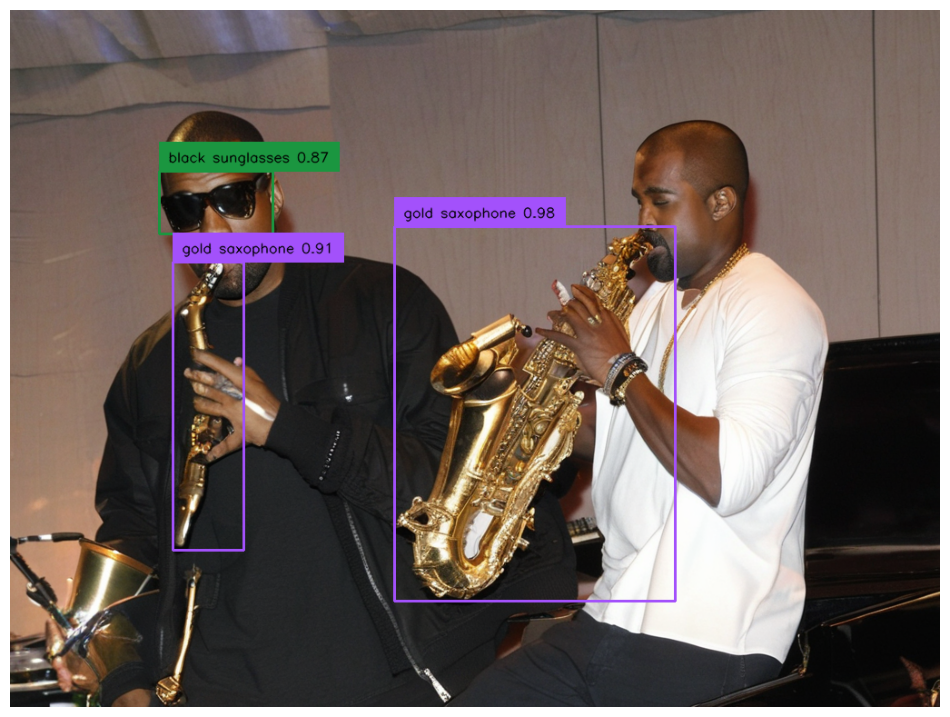

In [23]:
annotated_image = bounding_box_annotator.annotate(image, valid_detections)
annotated_image = label_annotator.annotate(annotated_image, valid_detections, labels)

sv.plot_image(annotated_image, (12, 12))

## Testing it automatically

We can also test if all requested objects are in the generated image by comparing a set of ground-truth labels with predicted ones:

In [26]:
GROUND_TRUTH = {"  saxophone ", " sunglasses "}
prediction = {CLASSES[class_id] for class_id in valid_detections.class_id}

prediction.issubset(GROUND_TRUTH)

False

Using [sv.Detections](https://supervision.roboflow.com/latest/detection/core/#supervision.detection.core.Detections) makes it super easy to do.

## Next steps

In this tutorial you learned how to detect and visualize objects for a simple image generation evaluation study.

Having a pipeline capable of evaluating a single image, the natural next step should be to run it on a set of pre-defined scenarios and calculate metrics.